   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 19.5 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Accuracy: 90.10%

📊 Classification Report:
                       precision    recall  f1-score   support

       not offensive       0.94      0.94      0.94       253
  offensive targeted       0.85      0.67      0.75        49
offensive untargeted       0.82      0.91      0.87        92

            accuracy                           0.90       394
           macro avg       0.87      0.84      0.85       394
        weighted avg       0.90      0.90      0.90       394



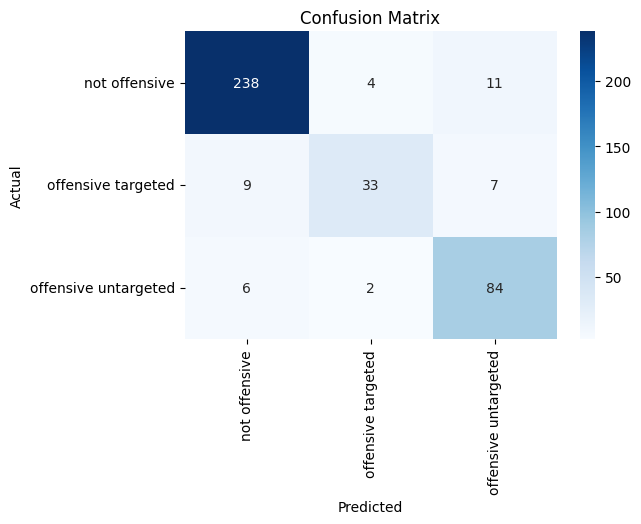

✅ Submission file saved to /content/drive/MyDrive/Dataset/Tulu/Tulu_LinearSVC_Results.csv


In [1]:
#LinearSVC
!pip install emoji

import re
import emoji
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from google.colab import drive

# ✅ Mount Google Drive
drive.mount("/content/drive")

# ✅ Load dataset
train_df = pd.read_csv("/content/drive/MyDrive/Dataset/Tulu/Tulu_offensive_train.csv")
dev_df   = pd.read_csv("/content/drive/MyDrive/Dataset/Tulu/Tulu_offensive_dev.csv")
test_df  = pd.read_csv("/content/drive/MyDrive/Dataset/Tulu/Tulu_test_data_without_label.csv")

# ✅ Lighter preprocessing function
def preprocess_text_light(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()                                     # lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", " ", text)         # remove URLs
    text = re.sub(r"\d+", " ", text)                             # remove numbers
    text = re.sub(r"\s+", " ", text).strip()                     # remove extra spaces
    return text

# ✅ Apply preprocessing only to train set
train_df["Text"] = train_df["Text"].astype(str).apply(preprocess_text_light)

# ✅ Drop missing values
train_df = train_df.dropna(subset=["Text", "Label"])

# ✅ Label Encoding
label_map = {
    "not offensive": 0,
    "offensive targeted": 1,
    "offensive untargeted": 2
}
train_df["Label"] = train_df["Label"].map(label_map)
train_df = train_df.dropna(subset=["Label"])

# ✅ Train-Test Split (from training data only)
X_train, X_test, y_train, y_test = train_test_split(
    train_df["Text"], train_df["Label"],
    test_size=0.2,
    stratify=train_df["Label"],
    random_state=42
)

# ✅ TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=15000, ngram_range=(1,3))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)

# ✅ LinearSVC Model
svm_model = LinearSVC(C=1.0, class_weight='balanced', max_iter=10000)
svm_model.fit(X_train_tfidf, y_train)

# ✅ Predictions on validation split
y_pred = svm_model.predict(X_test_tfidf)

# ✅ Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Accuracy: {accuracy:.2%}")
print("\n📊 Classification Report:\n", classification_report(
    y_test, y_pred, target_names=label_map.keys()
))

# ✅ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_map.keys(),
            yticklabels=label_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ============================
# 🚀 Final Test Predictions
# ============================

# ✅ Preprocess Test Data
test_df["Text"] = test_df["Text"].astype(str).apply(preprocess_text_light)

# ✅ Transform using fitted TF-IDF
X_test_final = vectorizer.transform(test_df["Text"])

# ✅ Predict with trained model
test_preds = svm_model.predict(X_test_final)

# ✅ Reverse label map
reverse_label_map = {v: k for k, v in label_map.items()}
test_labels = [reverse_label_map[p] for p in test_preds]

# ✅ Final submission format
submission = pd.DataFrame({
    "ID": test_df["ID"],         # keep original IDs
    "labels": test_labels        # add predicted labels
})

# ✅ Save submission file
output_path = "/content/drive/MyDrive/Dataset/Tulu/Tulu_LinearSVC_Results.csv"
submission.to_csv(output_path, index=False)

print(f"✅ Submission file saved to {output_path}")
